<a href="https://colab.research.google.com/github/kridtapon/CCI-Vortex-Reversal-System/blob/main/CCI_Vortex_Reversal_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.52
    Uninstalling yfinance-0.2.52:
      Successfully uninstalled yfinance-0.2.52


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Best Parameters:
CCI Period        34.00000
Vortex Period     30.00000
Total Return     195.11483
Name: 1359, dtype: float64


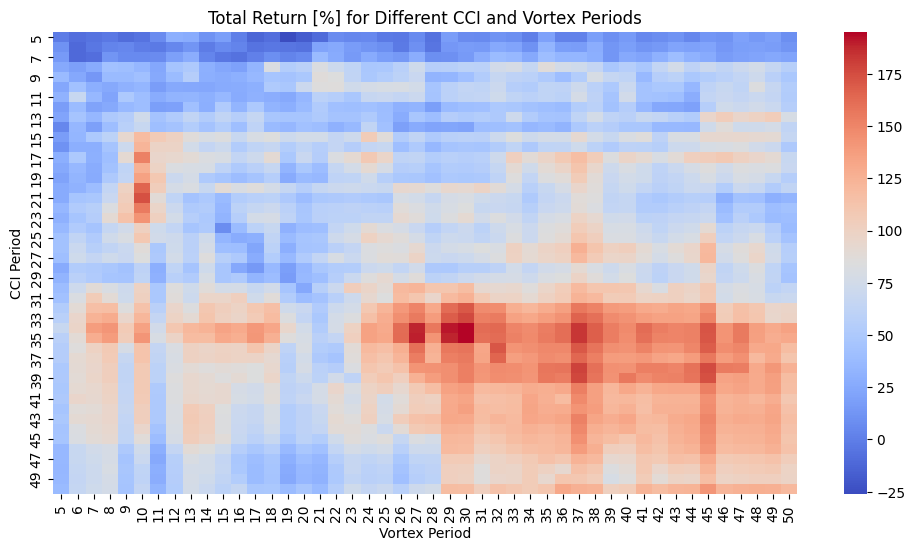

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Function to calculate Commodity Channel Index (CCI)
def calculate_cci(df, period):
    tp = (df['High'] + df['Low'] + df['Close']) / 3  # Typical Price
    ma = tp.rolling(window=period).mean()
    md = (tp - ma).abs().rolling(window=period).mean()
    cci = (tp - ma) / (0.015 * md)
    return cci

# Function to calculate Vortex Indicator (VI)
def calculate_vortex(df, period):
    tr = np.maximum(df['High'] - df['Low'],
                    np.maximum(abs(df['High'] - df['Close'].shift(1)), abs(df['Low'] - df['Close'].shift(1))))
    vm_plus = abs(df['High'] - df['Low'].shift(1))
    vm_minus = abs(df['Low'] - df['High'].shift(1))
    vi_plus = vm_plus.rolling(window=period).sum() / tr.rolling(window=period).sum()
    vi_minus = vm_minus.rolling(window=period).sum() / tr.rolling(window=period).sum()
    return vi_plus, vi_minus

# Define the stock symbol and time period
symbol = 'WMT'  # Example stock symbol
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download historical data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define parameter ranges
cci_periods = range(5, 51)  # Test CCI periods from 5 to 50
vortex_periods = range(5, 51)  # Test Vortex periods from 5 to 50

# Store results
results = []

# Iterate over all parameter combinations
for cci_p, vortex_p in product(cci_periods, vortex_periods):
    df['CCI'] = calculate_cci(df, period=cci_p)
    df['VI+'], df['VI-'] = calculate_vortex(df, period=vortex_p)

    # Define Entry and Exit signals
    df['Entry'] = ((df['CCI'] > 100) & (df['VI+'] > df['VI-'])) | ((df['CCI'] < -100) & (df['VI-'] > df['VI+']))
    df['Exit'] = ((df['VI+'] < df['VI-']) & (df['CCI'] > 0)) | ((df['VI-'] < df['VI+']) & (df['CCI'] < 0))

    # Filter data for backtesting (2020-2025)
    df_filtered = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Run backtest
    portfolio = vbt.Portfolio.from_signals(
        close=df_filtered['Close'],
        entries=df_filtered['Entry'],
        exits=df_filtered['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store performance metrics
    stats = portfolio.stats()
    total_return = stats.loc['Total Return [%]']

    results.append((cci_p, vortex_p, total_return))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['CCI Period', 'Vortex Period', 'Total Return'])

# Find best parameter set based on highest Total Return [%]
best_params = results_df.sort_values(by='Total Return', ascending=False).iloc[0]

print("Best Parameters:")
print(best_params)

# Plot parameter performance
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
heatmap_data = results_df.pivot(index='CCI Period', columns='Vortex Period', values='Total Return')
sns.heatmap(heatmap_data, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Total Return [%] for Different CCI and Vortex Periods")
plt.show()


In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from scipy.signal import argrelextrema

# Function to calculate Commodity Channel Index (CCI)
def calculate_cci(df, period=20):
    tp = (df['High'] + df['Low'] + df['Close']) / 3  # Typical Price
    ma = tp.rolling(window=period).mean()
    md = (tp - ma).abs().rolling(window=period).mean()
    cci = (tp - ma) / (0.015 * md)
    return cci

# Function to calculate Vortex Indicator (VI)
def calculate_vortex(df, period=14):
    tr = np.maximum(df['High'] - df['Low'],
                    np.maximum(abs(df['High'] - df['Close'].shift(1)), abs(df['Low'] - df['Close'].shift(1))))
    vm_plus = abs(df['High'] - df['Low'].shift(1))
    vm_minus = abs(df['Low'] - df['High'].shift(1))
    vi_plus = vm_plus.rolling(window=period).sum() / tr.rolling(window=period).sum()
    vi_minus = vm_minus.rolling(window=period).sum() / tr.rolling(window=period).sum()
    return vi_plus, vi_minus

# Define the stock symbol and time period
symbol = 'WMT'  # Example stock symbol
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download historical data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

df['CCI'] = calculate_cci(df, period=34)
df['VI+'], df['VI-'] = calculate_vortex(df, period=30)

# Define Entry and Exit signals based on CCI and Vortex Indicator
df['Entry'] = ((df['CCI'] > 100) & (df['VI+'] > df['VI-'])) | ((df['CCI'] < -100) & (df['VI-'] > df['VI+']))
df['Exit'] = ((df['VI+'] < df['VI-']) & (df['CCI'] > 0)) | ((df['VI-'] < df['VI+']) & (df['CCI'] < 0))

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           295114.830326
Total Return [%]                        195.11483
Benchmark Return [%]                   145.632566
Max Gross Exposure [%]                      100.0
Total Fees Paid                      10917.572921
Max Drawdown [%]                        16.470473
Max Drawdown Duration                       227.0
Total Trades                                   33
Total Closed Trades                            33
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            75.757576
Best Trade [%]                          24.166693
Worst Trade [%]                         -5.599988
Avg Winning Trade [%]                      5.5477
Avg Losing Trade [%]                    -2.932206
